In [1]:
import pnet_loader
import sankey_diag
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.nn as nn
import os

%load_ext autoreload
%autoreload 2

In [2]:
gene_cn = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_gene_cn.csv').set_index('Unnamed: 0')
gene_cn.rename(columns=dict(zip(gene_cn.columns, [x.split(' ')[0] for x in gene_cn.columns])), inplace=True)

In [3]:
muts = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_mutations.csv')
muts.dropna(subset=['Variant_Classification'], inplace=True)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (5,21,27,28,29,30,31,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
MUTATIONS_DICT = util.MUTATIONS_DICT

In [5]:
grouped_muts = muts[muts['Variant_Classification'].apply(lambda x: MUTATIONS_DICT[x]) != 'Silent'][['Hugo_Symbol',
                                                                                                    'Variant_Classification',
                                                                                                    'Tumor_Sample_Barcode']].groupby(['Tumor_Sample_Barcode',
                                                                                                                                          'Hugo_Symbol']).count()
mut = grouped_muts.unstack(level=-1).fillna(0).droplevel(0, axis=1)

In [6]:
kmt2d_target = pd.DataFrame(mut['KMT2D'] > 0).astype(int)
kmt2d_target.rename(columns=dict.fromkeys(['KMT2D'],'KMT2D_mut'), inplace=True)

In [7]:
p53_target = pd.DataFrame(mut['TP53'] > 0).astype(int)
p53_target.rename(columns=dict.fromkeys(['TP53'],'TP53_mut'), inplace=True)

In [10]:
rna = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_expression_full.csv').set_index('Unnamed: 0')
rna.rename(columns=dict(zip(rna.columns, [x.split(' ')[0] for x in rna.columns])), inplace=True)

In [11]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))
canc_genes.remove('TP53')
canc_genes.remove('KMT2D')

In [12]:
genetic_data = {'rna': rna, 'mut': mut}

Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1065, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated 

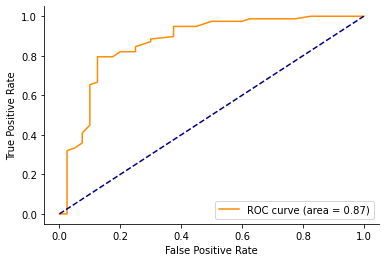

In [13]:
for i in range(10):
    path = '../results/ccle_val_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/ccle/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/ccle/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=p53_target,
                                                                  train_inds=train_inds, test_inds=test_inds, gene_set=canc_genes)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Found 705 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Found 705 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping ge

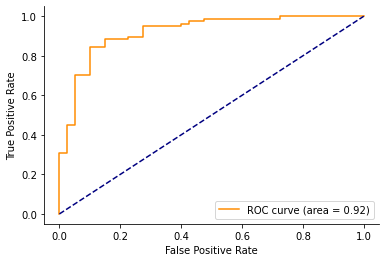

In [14]:
class_weights = util.get_class_weights(torch.tensor(p53_target.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/ccle/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/ccle/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, p53_target, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=64, epochs=400, early_stopping=True, 
                                                                             loss_weight=class_weights, train_inds=train_inds, test_inds=test_inds,
                                                                             save_path='../results/ccle_val/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ccle_val/run{}'.format(i))

Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1065, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated 

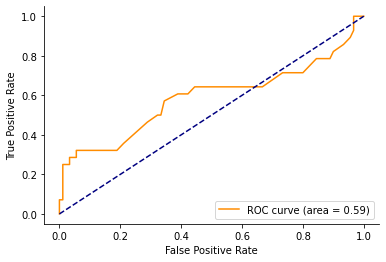

In [15]:
for i in range(10):
    path = '../results/ccle_val_kmt2d_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/ccle_KMT2D/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/ccle_KMT2D/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=kmt2d_target,
                                                                  train_inds=train_inds, test_inds=test_inds, gene_set=canc_genes)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Found 705 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping genes
generated input DataFrame of size (1064, 1410)
Initializing Test Dataset
Found 705 overlapping genes
generated input DataFrame of size (119, 1410)
Found 705 overlapping genes
We are sending to cuda
Hit early stopping criteria
Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 705 overlapping ge

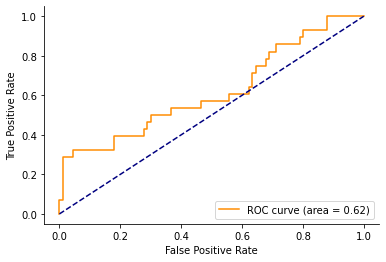

In [16]:
class_weights = util.get_class_weights(torch.tensor(kmt2d_target.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/ccle_KMT2D/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/ccle_KMT2D/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, kmt2d_target, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=64, epochs=400, early_stopping=True, 
                                                                             loss_weight=class_weights, train_inds=train_inds, test_inds=test_inds,
                                                                             save_path='../results/ccle_val_kmt2d/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ccle_val_kmt2d/run{}'.format(i))

In [17]:
models = ['ccle_val', 'ccle_val_rf', 'ccle_val_kmt2d', 'ccle_val_kmt2d_rf']
listl = []
for ds in models:
    for i in range(10):
        auc = torch.load('../results/{}/run{}/AUC.pt'.format(ds, i))
        rf = ds.split('_')[-1]
        ds_ = ds.split('_')[-2:]
        if rf == 'rf':
            listl.append([auc.item(), ds_[0], 'RF'])
        else:
            listl.append([auc.item(), ds_[1], 'P-Net'])

auc_df = pd.DataFrame(listl, columns=['AUC', 'Data Set', 'Model'])
auc_df['Data Set'] = auc_df['Data Set'].apply(lambda x: x.upper() if x=='kmt2d' else 'TP53')

In [18]:
auc_df.groupby(['Data Set', 'Model']).mean()

AUC
Data Set Model          
KMT2D    P-Net  0.767320
         RF     0.732441
TP53     P-Net  0.907241
         RF     0.880717

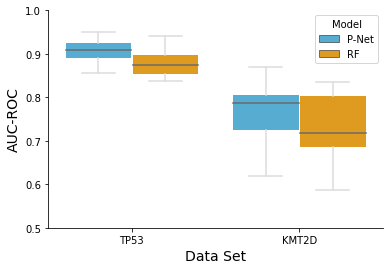

In [19]:
custom_colors = {'P-Net': '#41B6E6', 'RF': '#FFA300'}
sns.boxplot(data=auc_df, y='AUC', x='Data Set', hue='Model', showfliers=False, palette=custom_colors,
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                        boxprops={'edgecolor': 'none'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('AUC-ROC', size=14)
ax.set_xlabel('Data Set', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/CCLE_mut_prediction_auc.pdf')
plt.show()

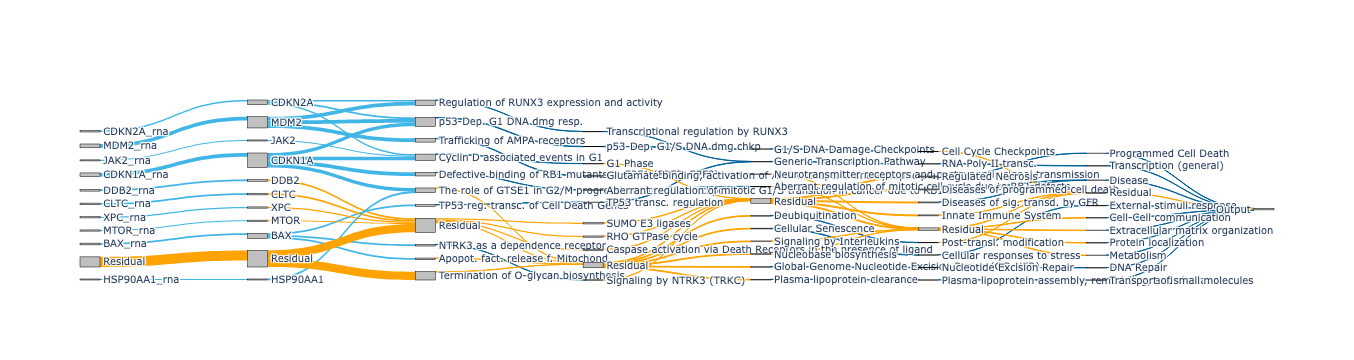

In [23]:
imps_dir = '/mnt/disks/pancan/pnet/results/ccle_val'
savepath = '/mnt/disks/pancan/pnet/figures/ccle_sankey_diagram.html'
sk = sankey_diag.SankeyDiag(imps_dir, runs=10)
fig = sk.get_sankey_diag(savepath)

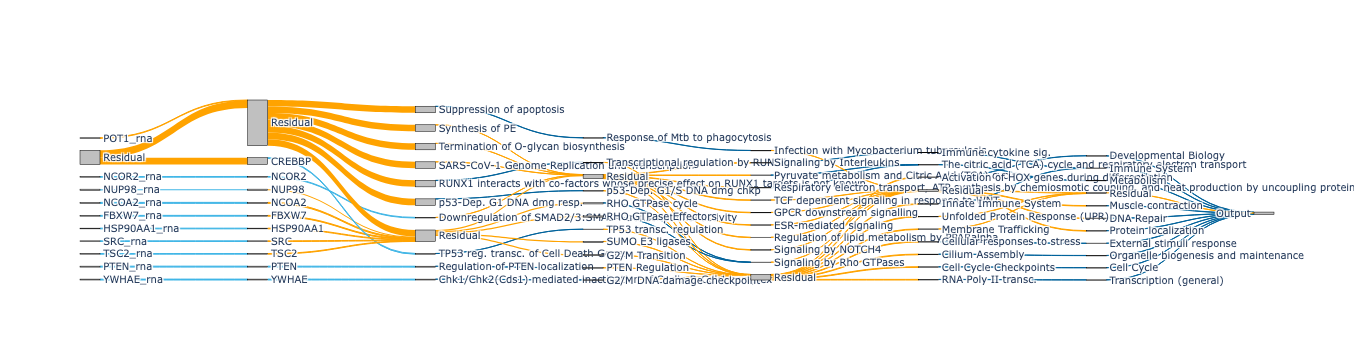

In [24]:
imps_dir = '/mnt/disks/pancan/pnet/results/ccle_val_kmt2d'
savepath = '/mnt/disks/pancan/pnet/figures/ccle_kmt2d_sankey_diagram.html'
sk = sankey_diag.SankeyDiag(imps_dir, runs=10)
fig = sk.get_sankey_diag(savepath)